# Fingernails Dataset

In [3]:
from google.colab import drive
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
import skimage.io as skio
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Check if the directory is empty. If it isn't list the contents so the user can diagnose.
if os.path.exists('/content/drive') and os.listdir('/content/drive'):
  print("The /content/drive directory is not empty and contains the following files:")
  for item in os.listdir('/content/drive'):
    print(item)

else:
  # If the directory is empty or doesn't exist, proceed with mounting.
  drive.mount('/content/drive')

The /content/drive directory is not empty and contains the following files:
.shortcut-targets-by-id
MyDrive
.file-revisions-by-id
.Trash-0
.Encrypted


In [6]:
!cp "/content/drive/MyDrive/selected_fingernails.zip" "/content/"

# Children Dataset

In [7]:
!unzip "/content/drive/MyDrive/selected_fingernails.zip"

Archive:  /content/drive/MyDrive/selected_fingernails.zip
  inflating: image_443_non_anemic.jpg  
  inflating: image_363_anemic.jpg    
  inflating: image_129_anemic.jpg    
  inflating: image_285_anemic.jpg    
  inflating: image_267_anemic.jpg    
  inflating: image_662_non_anemic.jpg  
  inflating: image_248_anemic.jpg    
  inflating: image_43_anemic.jpg     
  inflating: image_506_non_anemic.jpg  
  inflating: image_110_anemic.jpg    
  inflating: image_375_anemic.jpg    
  inflating: image_284_anemic.jpg    
  inflating: image_394_non_anemic.jpg  
  inflating: image_298_anemic.jpg    
  inflating: image_482_non_anemic.jpg  
  inflating: image_446_non_anemic.jpg  
  inflating: image_18_anemic.jpg     
  inflating: image_157_anemic.jpg    
  inflating: image_109_anemic.jpg    
  inflating: image_708_non_anemic.jpg  
  inflating: image_247_anemic.jpg    
  inflating: image_468_non_anemic.jpg  
  inflating: image_132_anemic.jpg    
  inflating: image_434_non_anemic.jpg  
  inflating:

In [8]:
import os

dataset_folder = '/content'

# Counters for each class
non_anemic_count = 0
anemic_count = 0

for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)

    if not os.path.isfile(file_path):
        continue

    file_ext = os.path.splitext(filename)[1]

    if 'non' in filename.lower():  # non-anemic (0)
        new_name = f"0_{non_anemic_count}{file_ext}"
        non_anemic_count += 1
    else:  # anemic (1)
        new_name = f"1_{anemic_count}{file_ext}"
        anemic_count += 1

    new_path = os.path.join(dataset_folder, new_name)
    os.rename(file_path, new_path)

print(f"Renaming completed: {non_anemic_count} non-anemic (0) and {anemic_count} anemic (1) images.")

Renaming completed: 375 non-anemic (0) and 377 anemic (1) images.


# Adults Dataset

In [9]:
!cp "/content/drive/MyDrive/clustered_images.zip" "/content/"

In [10]:
!unzip "/content/drive/MyDrive/clustered_images.zip"

Archive:  /content/drive/MyDrive/clustered_images.zip
 extracting: 0_orig_296_197_anemic_nail_1.jpg  
 extracting: 0_orig_253_133_non_anemic_nail_2.jpg  
 extracting: 0_orig_664_87_anemic_nail_0.jpg  
 extracting: 1_orig_517_103_non_anemic_nail_0.jpg  
 extracting: 0_orig_131_191_non_anemic_nail_0.jpg  
 extracting: 0_orig_147_294_non_anemic_nail_1.jpg  
 extracting: 1_orig_473_280_anemic_nail_2.jpg  
 extracting: 0_orig_395_194_anemic_nail_2.jpg  
 extracting: 0_orig_629_49_non_anemic_nail_2.jpg  
 extracting: 1_orig_594_86_anemic_nail_0.jpg  
 extracting: 1_orig_393_315_anemic_nail_0.jpg  
 extracting: 1_orig_749_222_non_anemic_nail_2.jpg  
 extracting: 0_orig_72_261_anemic_nail_0.jpg  
 extracting: 0_orig_229_125_non_anemic_nail_0.jpg  
 extracting: 0_orig_368_25_non_anemic_nail_0.jpg  
 extracting: 0_orig_428_28_non_anemic_nail_2.jpg  
 extracting: 1_orig_210_48_non_anemic_nail_0.jpg  
 extracting: 0_orig_584_129_non_anemic_nail_0.jpg  
 extracting: 1_orig_709_194_anemic_nail_0.jpg

In [11]:

# Path to the unzipped folder
dataset_folder = '/content'


# Initialize lists to store images and labels
anemic_images = []
non_anemic_images = []

# Loop through all files in the folder
for filename in os.listdir(dataset_folder):
  if 'orig' in filename:
    if filename.startswith('0'):
        img = cv2.imread(os.path.join(dataset_folder, filename))
        if img is not None:
            non_anemic_images.append(img)
    else:
        img = cv2.imread(os.path.join(dataset_folder, filename))
        if img is not None:
            anemic_images.append(img)

print(f"Loaded {len(anemic_images)} anemic images and {len(non_anemic_images)} non-anemic images.")


Loaded 295 anemic images and 455 non-anemic images.


In [12]:

'''
import zipfile
from PIL import Image
import io

def load_images_and_labels_from_zip(zip_path):
    images = []
    labels = []

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for filename in zipf.namelist():
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Extract label from filename (prefix before first underscore)
                label = int(filename.split('_')[0])
                labels.append(label)


                # Read image from zip
                with zipf.open(filename) as img_file:
                      img = Image.open(io.BytesIO(img_file.read())).convert('RGB')
                      img = img.resize((224, 224))
                      img_array = np.array(img) / 255.0
                      images.append(img_array)

    return np.array(images), labels

images, labels = load_images_and_labels_from_zip('clustered_images.zip')
print(f"Loaded {len(images)} images with labels: {set(labels)}")
'''

'\nimport zipfile\nfrom PIL import Image\nimport io\n\ndef load_images_and_labels_from_zip(zip_path):\n    images = []\n    labels = []\n\n    with zipfile.ZipFile(zip_path, \'r\') as zipf:\n        for filename in zipf.namelist():\n            if filename.lower().endswith((\'.jpg\', \'.jpeg\', \'.png\')):\n                # Extract label from filename (prefix before first underscore)\n                label = int(filename.split(\'_\')[0])\n                labels.append(label)\n\n\n                # Read image from zip\n                with zipf.open(filename) as img_file:\n                      img = Image.open(io.BytesIO(img_file.read())).convert(\'RGB\')\n                      img = img.resize((224, 224))\n                      img_array = np.array(img) / 255.0\n                      images.append(img_array)\n\n    return np.array(images), labels\n\nimages, labels = load_images_and_labels_from_zip(\'clustered_images.zip\')\nprint(f"Loaded {len(images)} images with labels: {set(labels

# Combining the two datasets


In [13]:


dataset_1_folder = '/content'  #  dataset folder
total_dataset_folder = '/content/total_datasets'  # Folder to store combined images

# Create the total_dataset folder if it doesn't exist
os.makedirs(total_dataset_folder, exist_ok=True)

# Define common image file extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

# Function to copy images from a folder to the total_dataset folder
def copy_images_from_folder(source_folder):
    counter=0
    for filename in os.listdir(source_folder):
        # Check if the file has an image extension
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(total_dataset_folder, filename)
            shutil.copy(source_path, destination_path)
            counter+=1
            print(f"Copied {filename} from {source_folder} to total_dataset")
    print(f'total images :{counter}')

# Copy all images from the first dataset (Fingernails) to the total dataset folder
copy_images_from_folder(dataset_1_folder)


print("All images have been successfully copied to the total_dataset folder.")


Copied 0_orig_296_197_anemic_nail_1.jpg from /content to total_dataset
Copied 0_orig_253_133_non_anemic_nail_2.jpg from /content to total_dataset
Copied 1_302.jpg from /content to total_dataset
Copied 1_178.jpg from /content to total_dataset
Copied 0_19.jpg from /content to total_dataset
Copied 0_orig_664_87_anemic_nail_0.jpg from /content to total_dataset
Copied 1_orig_517_103_non_anemic_nail_0.jpg from /content to total_dataset
Copied 1_211.jpg from /content to total_dataset
Copied 0_2.jpg from /content to total_dataset
Copied 0_orig_131_191_non_anemic_nail_0.jpg from /content to total_dataset
Copied 0_317.jpg from /content to total_dataset
Copied 0_orig_147_294_non_anemic_nail_1.jpg from /content to total_dataset
Copied 1_orig_473_280_anemic_nail_2.jpg from /content to total_dataset
Copied 0_orig_395_194_anemic_nail_2.jpg from /content to total_dataset
Copied 0_orig_629_49_non_anemic_nail_2.jpg from /content to total_dataset
Copied 1_88.jpg from /content to total_dataset
Copied 1_29

In [16]:

#Load and preprocess the combined dataset
def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load image
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                # Resize and normalize
                img = cv2.resize(img, target_size)
                img = img.astype('float32') / 255.0
                images.append(img)

                # Extract label from filename
                if filename.startswith('1'):
                    labels.append(1)  # Anemic
                elif filename.startswith('0'):
                    labels.append(0)  # Non-anemic
                else:
                    labels.append(-1)  # Unknown

    return np.array(images), np.array(labels)


# Feature Extraction (AutoEncoder)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,851 (1.28 MB)

 Trainable params: 334,403 (1.28 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - loss: 0.0157 - val_loss: 0.0615
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0028 - val_loss: 0.0522
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0017 - val_loss: 0.0495
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0019 - val_loss: 0.0235
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0012 - val_loss: 6.4255e-04
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - los

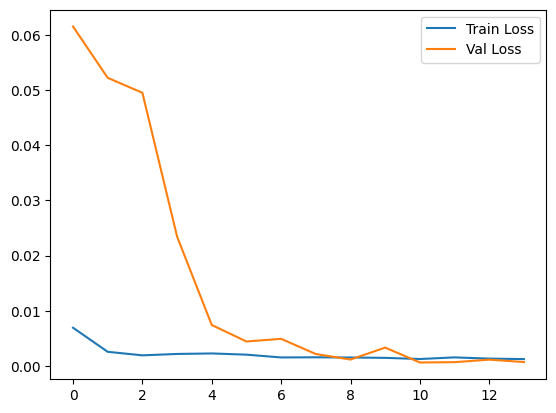

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Feature extraction complete! Files saved in /content/features


In [17]:

X, y = load_and_preprocess_images('/content/total_datasets')
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain label balance
)

#  Build autoencoder
def build_autoencoder(input_shape=(224,224,3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    encoder = Model(input_img, encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
autoencoder.summary()

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping]
)

# Plot training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# Feature extraction
def extract_features(encoder, images, batch_size=32):
    features = encoder.predict(images, batch_size=batch_size)
    return features.reshape(features.shape[0], -1)  # Flatten

train_features = extract_features(encoder, X_train)
val_features = extract_features(encoder, X_val)

#  Save features
os.makedirs('/content/features', exist_ok=True)
np.save('/content/features/train_features.npy', train_features)
np.save('/content/features/train_labels.npy', y_train)
np.save('/content/features/val_features.npy', val_features)
np.save('/content/features/val_labels.npy', y_val)

print("\nFeature extraction complete! Files saved in /content/features")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


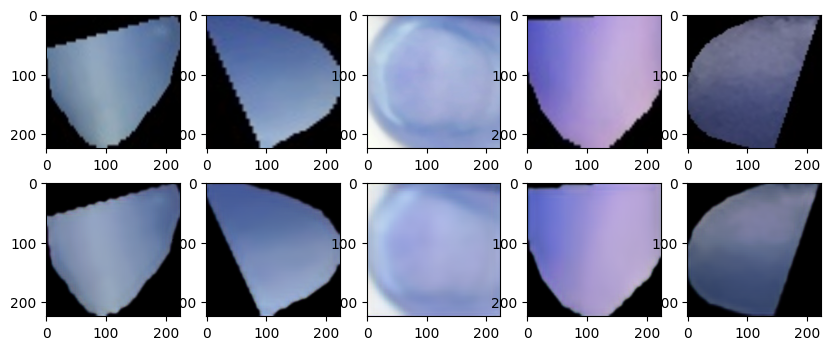

In [18]:
# Visualize some reconstructions
decoded_imgs = autoencoder.predict(X_val[:5])

plt.figure(figsize=(10,4))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(X_val[i])
    # Reconstruction
    plt.subplot(2,5,i+6)
    plt.imshow(decoded_imgs[i])
plt.show()

In [19]:
!zip -r features.zip features

  adding: features/ (stored 0%)
  adding: features/train_labels.npy (deflated 95%)
  adding: features/val_labels.npy (deflated 92%)
  adding: features/train_features.npy (deflated 44%)
  adding: features/val_features.npy (deflated 44%)


In [20]:
from google.colab import files
files.download("features.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>